In [293]:
import healpy as hp
import numpy as np
import matplotlib.pyplot as plt

from scipy.special import iv as Iv #Modified Bessel function of the first kind of real order.
import scipy.special as sc

from scipy.stats import rice

from scipy.stats.mstats import gmean
from multiprocessing import cpu_count

from pathos.pools import ProcessPool as Pool

from utilities import Mask, Bp2f
import copy 

import seaborn as sea
import pandas as pd

%config Completer.use_jedi = False
%matplotlib inline

In [33]:
nside = 32; names = ['SPASS only', 'CBASS only', 'both']

In [5]:
total_P = np.load('/global/cscratch1/sd/jianyao/CBASS/Observations/homo_noise/totalP_s0_%s_uK_RJ_000.npy'%nside)#/1000 ## from uK to mK
total_sigma = np.load('/global/cscratch1/sd/jianyao/CBASS/Noise/homo_noise/5_fre_sigma_P_%s_uK_RJ.npy'%nside)#/1000 ## from uK to mK
P_nu0 = np.load('/global/cscratch1/sd/jianyao/CBASS/Foreground/P_11.99_s0_32_uK_RJ.npy')#/1000

mask_both = np.load('/global/cscratch1/sd/jianyao/CBASS/mask_both_%s.npy'%nside)
mask_index = np.load('/global/cscratch1/sd/jianyao/CBASS/masked_index.npy')

# for one noise realization

In [2]:
As_betas_both = np.load('/global/cscratch1/sd/jianyao/CBASS/Results/s0_only_homo_noise/Dyne_As_betas_masked_both_32_with_SPASS_CBASS_001.npy')
As_betas_S = np.load('/global/cscratch1/sd/jianyao/CBASS/Results/s0_only_homo_noise/Dyne_As_betas_masked_both_32_with_SPASS_only_001.npy')
As_betas_C = np.load('/global/cscratch1/sd/jianyao/CBASS/Results/s0_only_homo_noise/Dyne_As_betas_masked_both_32_with_CBASS_only_001.npy')

In [6]:
sn_both = gmean(total_P/total_sigma, axis = 0)
sn_C = gmean((total_P/total_sigma)[1:5], axis = 0)
sn_S = gmean([(total_P/total_sigma)[0],(total_P/total_sigma)[2],(total_P/total_sigma)[3],(total_P/total_sigma)[4]])

In [7]:
betas_both = Bp2f(As_betas_both, mask_index, nside = nside)[2]
sig_B_both = Bp2f(As_betas_both, mask_index, nside = nside)[3]

betas_C = Bp2f(As_betas_C, mask_index, nside = nside)[2]
sig_B_C = Bp2f(As_betas_C, mask_index, nside = nside)[3]
betas_S = Bp2f(As_betas_S, mask_index, nside = nside)[2]
sig_B_S = Bp2f(As_betas_S, mask_index, nside = nside)[3]

In [196]:
sns = np.array([sn_S[mask_index], sn_C[mask_index], sn_both[mask_index]]);
betas = np.array([betas_S[mask_index], betas_C[mask_index], betas_both[mask_index]])

betas_full = np.array([betas_S, betas_C, betas_both])
mc_error = np.array([sig_B_S, sig_B_C, sig_B_both])

bin_num = 60
SN_bins = np.linspace(np.log10(sns.min()), np.log10(sns.max()), bin_num + 1)
betas_bins = np.linspace(betas.min(),betas.max(), bin_num + 1)

for realization 1


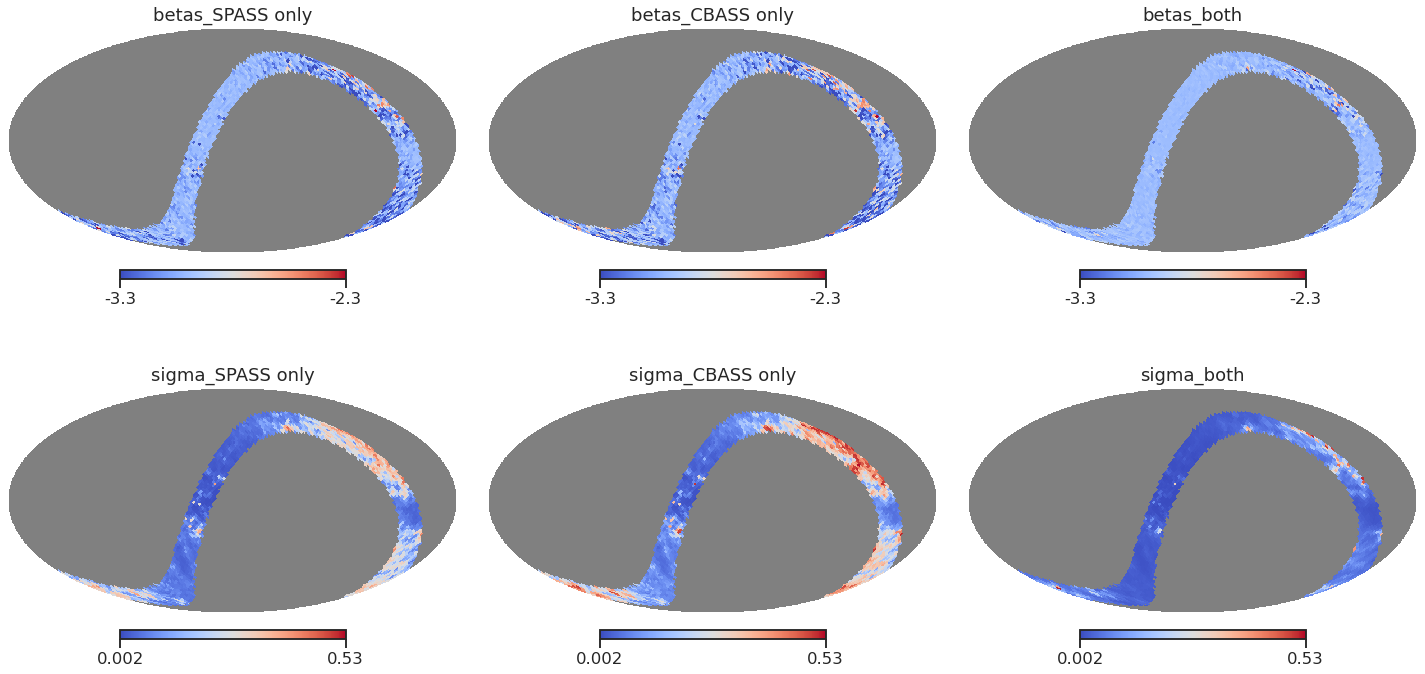

In [202]:
plot_sky_betas(betas_full, mc_error, names, title = 'for realization 1')

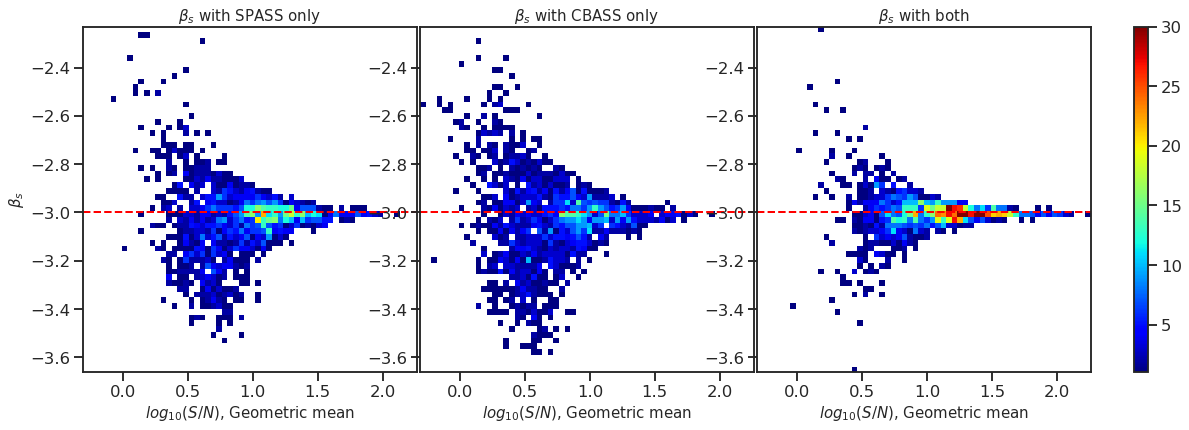

In [164]:
fig, ax = plt.subplots(1,3, figsize = (20,6))
my_cmap = copy.copy(plt.cm.get_cmap("jet"))
my_cmap.set_under('w',0)

for i in range(3):

    x0, y0 = sns[i], betas[i]
    counts, xedges, yedges, im  = ax[i].hist2d(np.log10(x0),y0, bins = [SN_bins, betas_bins], cmap = my_cmap, cmin = 1, vmax = 30)
    ax[i].set_title(r'$\beta_s$ with %s'%(names[i]), fontsize = 15)
    ax[i].axhline(-3.0, c = 'red', lw = 2, ls = '--')
    
    ax[i].set_xlabel(r'$log_{10}(S/N)$, Geometric mean', fontsize = 15)
    if i ==0:
        ax[i].set_ylabel(r'$\beta_s$', fontsize = 15)
    
fig.subplots_adjust(bottom=0.1, top=0.9, left=0.1, right=0.8,
                    wspace=0.01, hspace=0.02)    
cb_ax = fig.add_axes([0.83, 0.1, 0.01, 0.8])
cbar = fig.colorbar(im, cax=cb_ax)    

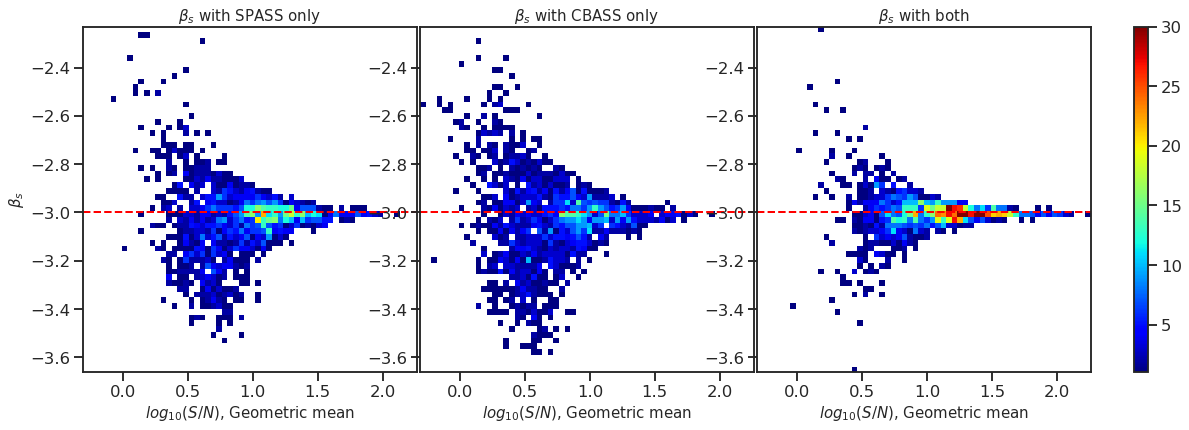

In [205]:
plot_2d(betas, sns, betas_bins, SN_bins, names)

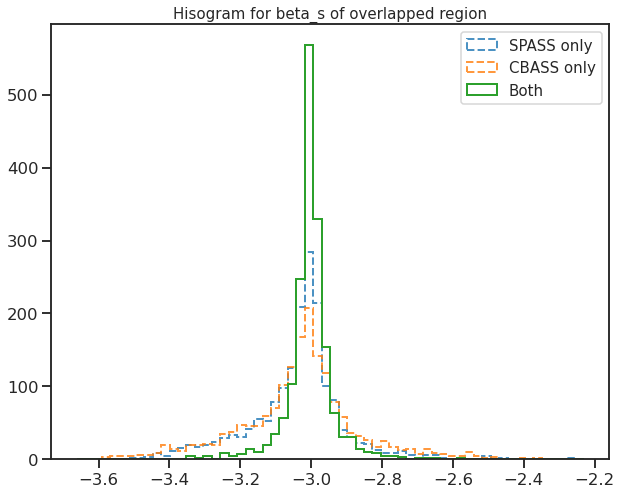

In [165]:
plt.figure(figsize = (10,8))
plt.hist(betas_S[mask_index],  bins = betas_bins, histtype="step", label = 'SPASS only', lw = 2, linestyle = '--',alpha = 0.8)

plt.hist(betas_C[mask_index], bins = betas_bins, histtype="step" , label = 'CBASS only', lw = 2, linestyle = '--',alpha = 0.8)

h = plt.hist(betas_both[mask_index],  bins = betas_bins, histtype="step" , label = 'Both', lw = 2)

plt.title('Hisogram for beta_s of overlapped region', fontsize = 15)
plt.legend(fontsize = 15)

In [371]:
sea.set_style("white")
sea.set_context("talk")
sea.set_style("ticks")

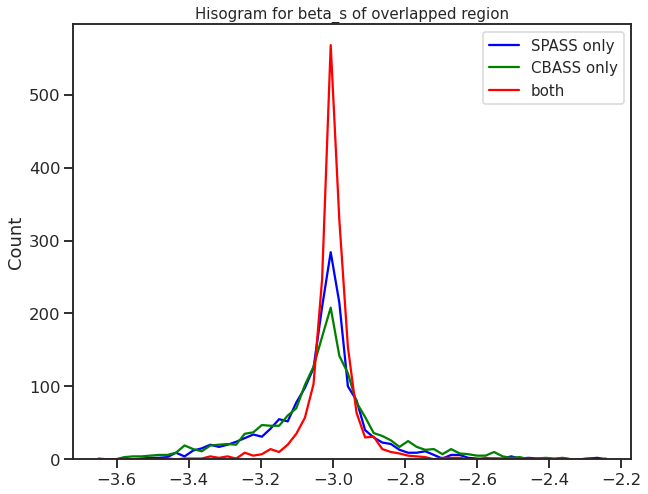

In [163]:
plt.figure(figsize = (10,8))

sea.histplot(betas[0], bins = betas_bins, fill=False, element="poly",label = 'SPASS only',color = 'blue')
sea.histplot(betas[1], bins = betas_bins, fill=False, element="poly",label = 'CBASS only',color = 'green')

sea.histplot(betas[2], bins = betas_bins, fill=False, element="poly",label = 'both',color = 'red')

plt.title('Hisogram for beta_s of overlapped region', fontsize = 15)
plt.legend(fontsize = 15)

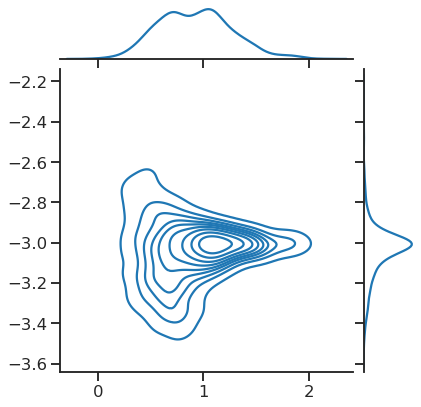

In [166]:
sea.jointplot(x = np.log10(sn_S[mask_index]), y=betas_S[mask_index], kind = 'kde')

# combine realizations

In [167]:
def combine(name,nside, N, mask_index):
    betas_all = np.zeros((N, 12*nside**2))
    for j in range(N):
        results= np.load('/global/cscratch1/sd/jianyao/CBASS/Results/s0_only_homo_noise/Dyne_As_betas_masked_both_%s_with_%s_%03d.npy'%(nside, name,j))
        betas_all[j] = Bp2f(results,mask_index, nside = nside)[2]
    
    mean = np.mean(betas_all, axis = 0)
    std = np.std(betas_all, axis = 0); std_masked = np.ma.masked_where(std>100, std)
    return mean, std_masked.filled(fill_value = hp.UNSEEN)



In [168]:
beta_both_mean = combine('SPASS_CBASS', 32, 50, mask_index)[0]
beta_both_std = combine('SPASS_CBASS', 32, 50, mask_index)[1]

beta_S_mean = combine('SPASS_only', 32, 50, mask_index)[0]
beta_S_std = combine('SPASS_only', 32, 50, mask_index)[1]

beta_C_mean = combine('CBASS_only', 32, 50, mask_index)[0]
beta_C_std = combine('CBASS_only', 32, 50, mask_index)[1]

In [200]:
def plot_sky_betas(betas, sigmas, cases, title):
    '''
    input: full-sky maps
    -------------
    betas, total set of recovered beta_s for each case. Shape(3, 12*nside**2);
    sigmas, total set of error of beta_s for each case. Shape(3, 12*nside**2);
    cases, names for each case.
    '''
    plt.figure(figsize = (20, 10))
    print(title)
    for i in range(len(betas)):
    
        hp.mollview(betas[i], cmap = 'coolwarm', sub = int('23%s'%(i+1)), title = 'betas_%s'%cases[i], min = -3.3, max = -2.3)
        hp.mollview(sigmas[i], cmap = 'coolwarm', sub = int('23%s'%(i+4)), title = 'sigma_%s'%cases[i], min = 0.002, max = 0.53)


#     hp.mollview(betas_C, cmap = 'coolwarm', sub = 232, title = 'betas_C', min = -3.3, max = -2.3)
#     hp.mollview(sig_B_C, cmap = 'coolwarm', sub = 235, title = 'sigma_CBASS', min = 0.002, max = 0.53)

#     hp.mollview(betas_both, cmap = 'coolwarm',sub = 233, title = 'beta_s_both', min = -3.3, max = -2.3)
#     hp.mollview(sig_B_both, cmap = 'coolwarm', sub = 236, title = 'sigma_both', min = 0.002, max = 0.53)

In [206]:
mean_betas_full = np.array([beta_S_mean, beta_C_mean, beta_both_mean])
mean_betas = np.array([beta_S_mean[mask_index], beta_C_mean[mask_index], beta_both_mean[mask_index]])
std_betas = np.array([beta_S_std, beta_C_std, beta_both_std])

betas_for_50_realizations


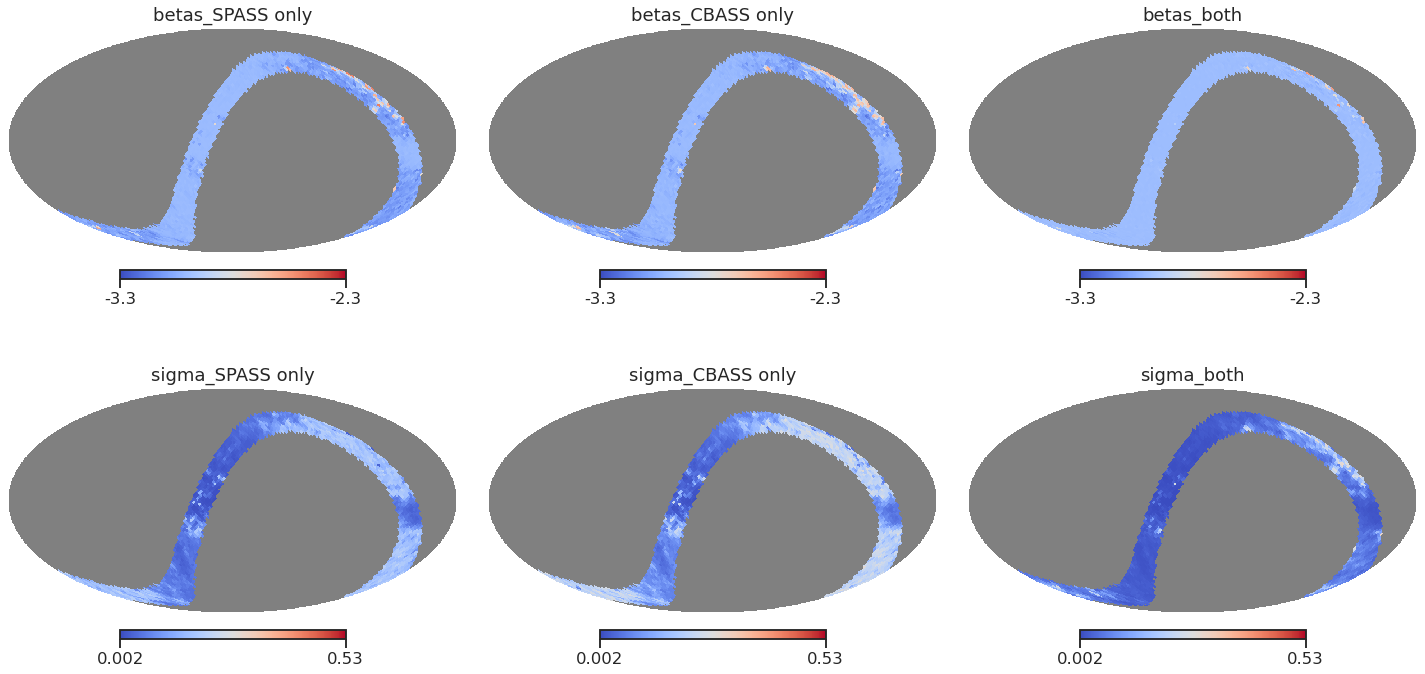

In [207]:
plot_sky_betas(mean_betas_full, std_betas, names, title = 'betas_for_50_realizations')

In [272]:
exceed_index[0].shape

(39,)

In [278]:
def one_sigma(betas, std):

    exceed_index = np.where(abs(betas +3) > std[mask_index])
    print(exceed_index[0].shape)
    one_sig = np.zeros(12*nside**2)
    index = np.arange(12*nside**2)

    one_sig[np.delete(index, mask_index)] = hp.UNSEEN
    one_sig[mask_index[exceed_index]] = 1
    
    return one_sig

$-3 \pm 1 \sigma$

(52,)
(68,)
(10,)


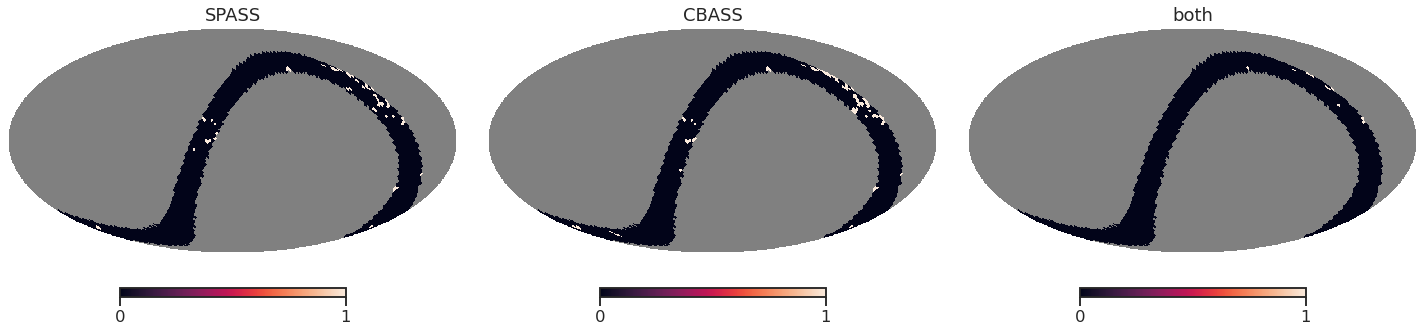

In [285]:
plt.figure(figsize = (20, 10))
hp.mollview(one_sigma(mean_betas[0], std_betas[0]), sub = 131, title = 'SPASS')
hp.mollview(one_sigma(mean_betas[1], std_betas[1]), sub = 132, title = 'CBASS')
hp.mollview(one_sigma(mean_betas[2], std_betas[2]), sub = 133, title = 'both')

In [204]:
def plot_2d(betas, sns, beta_bin, sn_bin, names):
    
    '''
    masked regions
    '''

    fig, ax = plt.subplots(1,3, figsize = (20,6))
    my_cmap = copy.copy(plt.cm.get_cmap("jet"))
    my_cmap.set_under('w',0)

    for i in range(3):

        x0, y0 = sns[i], betas[i]
        counts, xedges, yedges, im  = ax[i].hist2d(np.log10(x0),y0, bins = [sn_bin, beta_bin], cmap = my_cmap, cmin = 1, vmax = 30)
        ax[i].set_title(r'$\beta_s$ with %s'%(names[i]), fontsize = 15)
        ax[i].axhline(-3.0, c = 'red', lw = 2, ls = '--')

        ax[i].set_xlabel(r'$log_{10}(S/N)$, Geometric mean', fontsize = 15)
        if i ==0:
            ax[i].set_ylabel(r'$\beta_s$', fontsize = 15)

    fig.subplots_adjust(bottom=0.1, top=0.9, left=0.1, right=0.8,
                        wspace=0.01, hspace=0.02)    
    cb_ax = fig.add_axes([0.83, 0.1, 0.01, 0.8])
    cbar = fig.colorbar(im, cax=cb_ax)  

In [208]:
bin_num = 60
SN_bins = np.linspace(np.log10(sns.min()), np.log10(sns.max()), bin_num + 1)
mean_betas_bins = np.linspace(mean_betas.min(),mean_betas.max(), bin_num + 1)

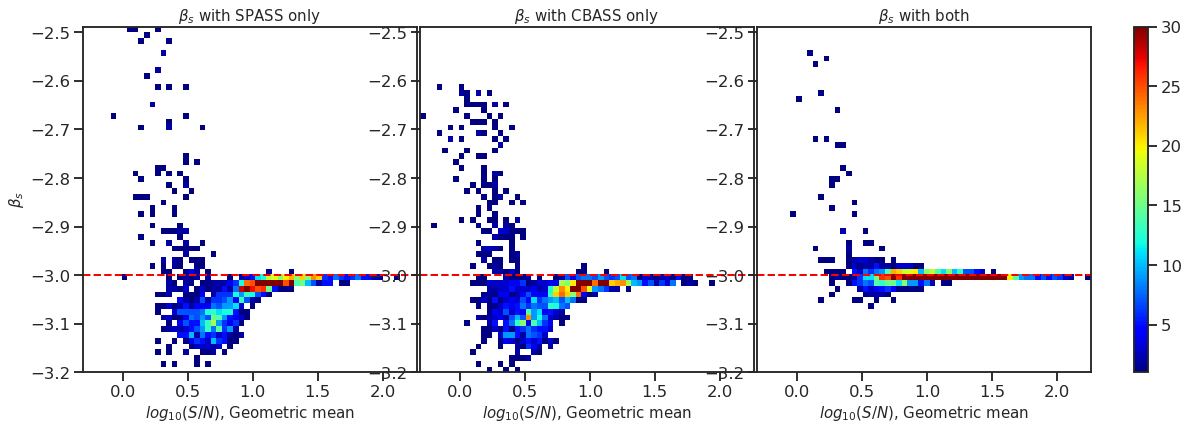

In [216]:
plot_2d(mean_betas, sns, mean_betas_bins, SN_bins, names = names)

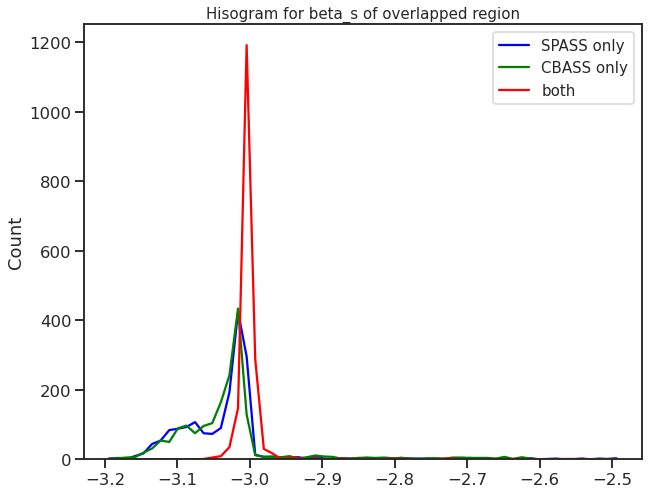

In [217]:
plt.figure(figsize = (10,8))

sea.histplot(mean_betas[0], bins = mean_betas_bins, fill=False, element="poly",label = 'SPASS only',color = 'blue')
sea.histplot(mean_betas[1], bins = mean_betas_bins, fill=False, element="poly",label = 'CBASS only',color = 'green')

sea.histplot(mean_betas[2], bins = mean_betas_bins, fill=False, element="poly",label = 'both',color = 'red')

plt.title('Hisogram for beta_s of overlapped region', fontsize = 15)
plt.legend(fontsize = 15)

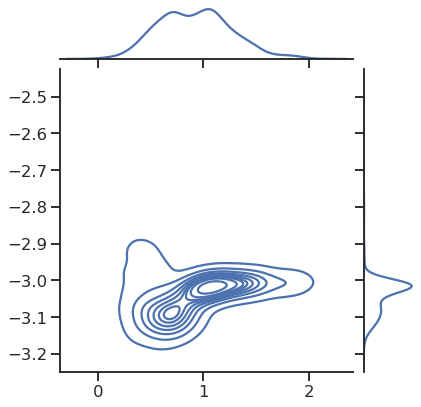

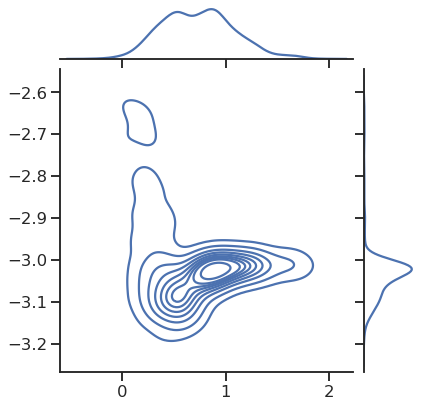

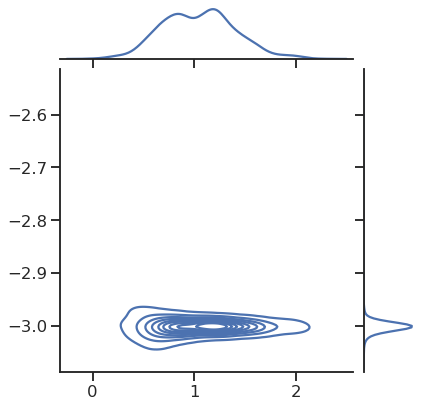

In [376]:
sea.jointplot(x = np.log10(sn_S[mask_index]), y=beta_S_mean[mask_index], kind = 'kde')
sea.jointplot(x = np.log10(sn_C[mask_index]), y=beta_C_mean[mask_index], kind = 'kde')
sea.jointplot(x = np.log10(sn_both[mask_index]), y=beta_both_mean[mask_index], kind = 'kde')

In [322]:
results = np.zeros((1755*3, 3),dtype = 'object')

for i in range(3):
    
    results[1755*i:1755*(i+1), 0] = names[i]
    results[1755*i:1755*(i+1), 1] = mean_betas[i]
    results[1755*i:1755*(i+1), 2] = np.log10(sns[i])

In [346]:
convert_dict = {'cases': str,
                'beta_s': float,
                'SNR': float
               }

In [353]:
results = pd.DataFrame(results, columns = ['cases', 'beta_s', 'SNR'])
results = results.astype(convert_dict)

In [354]:
print(results.dtypes)

cases      object
beta_s    float64
SNR       float64
dtype: object


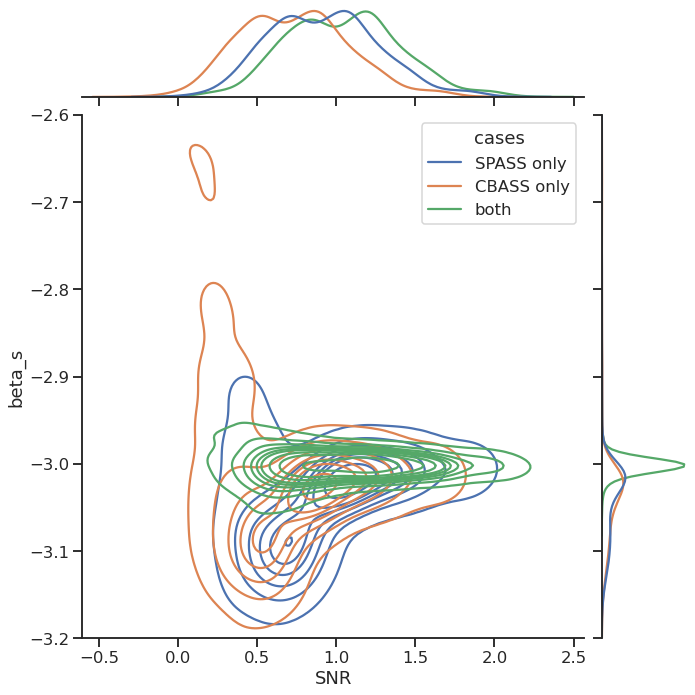

In [366]:
sea.jointplot(data=results, x="SNR", y="beta_s", hue="cases", kind="kde", height=10, ylim = [-3.2, -2.6])